In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.transform import Rotation
import scipy as sp

# Load Data

In [13]:
df_data = pd.read_csv("data/sorted_imu_data.csv")
df_data

,topic_x,time,gyro.x_x,gyro.y_x,gyro.z_x,acceleration.x_x,acceleration.y_x,acceleration.z_x,topic_y,gyro.x_y,gyro.y_y,gyro.z_y,acceleration.x_y,acceleration.y_y,acceleration.z_y
0,/ouster_top/imu,1.763743e+09,-0.007324,-0.007590,0.000000,0.138864,0.368707,9.698911,/inertial_sense/imu_raw,-0.001265,-0.000009,-0.004643,-0.143550,-0.400549,-9.778652
1,/ouster_top/imu,1.763743e+09,-0.006525,-0.003862,-0.003196,0.167594,0.263362,9.811438,/inertial_sense/imu_raw,0.001212,-0.000406,-0.002612,-0.135534,-0.376492,-9.778723
2,/ouster_top/imu,1.763743e+09,-0.015713,-0.015180,-0.005593,0.196325,0.354342,9.710882,/inertial_sense/imu_raw,0.000816,-0.002427,-0.001776,-0.135677,-0.406913,-9.796161
3,/ouster_top/imu,1.763743e+09,-0.010253,-0.013183,-0.004794,0.148441,0.313640,9.698911,/inertial_sense/imu_raw,-0.001245,-0.004508,-0.003008,-0.153142,-0.438814,-9.775452
4,/ouster_top/imu,1.763743e+09,-0.010786,-0.007590,-0.004394,0.201113,0.210690,9.660604,/inertial_sense/imu_raw,0.000409,0.001639,0.000670,-0.109775,-0.397305,-9.742225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10734,/ouster_top/imu,1.763743e+09,-0.008655,-0.001997,-0.005992,0.306458,-0.426168,9.713276,/inertial_sense/imu_raw,-0.001622,0.001505,-0.001775,-0.043451,0.362601,-9.764091
10735,/ouster_top/imu,1.763743e+09,-0.009188,-0.011052,-0.004794,0.217872,-0.593762,9.715670,/inertial_sense/imu_raw,0.002452,0.000726,-0.007517,-0.027617,0.297101,-9.765736
10736,/ouster_top/imu,1.763743e+09,-0.012251,-0.008522,-0.004794,0.395043,-0.239420,9.631873,/inertial_sense/imu_raw,0.004938,0.000280,-0.002657,0.014164,0.301829,-9.734167
10737,/ouster_top/imu,1.763743e+09,-0.007457,-0.013848,-0.001997,0.385466,-0.450110,9.672575,/inertial_sense/imu_raw,0.002487,0.005183,-0.002620,-0.016212,0.399236,-9.757871


# Set up variables

In [14]:
t = df_data['time'].to_numpy()
t = t - t[0]
x_plot = np.arange(len(df_data['gyro.x_x']))

g1x = df_data['gyro.x_x'].to_numpy()
g1y = df_data['gyro.y_x'].to_numpy()
g1z = df_data['gyro.z_x'].to_numpy()
g1 = np.stack([g1x, g1y, g1z]).T
print(g1.shape)

g2x = df_data['gyro.x_y'].to_numpy()
g2y = df_data['gyro.y_y'].to_numpy()
g2z = df_data['gyro.z_y'].to_numpy()
g2 = np.stack([g2x, g2y, g2z]).T

a1x = df_data['acceleration.x_x'].to_numpy()
a1y = df_data['acceleration.y_x'].to_numpy()
a1z = df_data['acceleration.z_x'].to_numpy()
a1 = np.stack([a1x, a1y, a1z]).T

a2x = df_data['acceleration.x_y'].to_numpy()
a2y = df_data['acceleration.y_y'].to_numpy()
a2z = df_data['acceleration.z_y'].to_numpy()
a2 = np.stack([a2x, a2y, a2z]).T

(10739, 3)


## Problem Formulation

Each IMU has a gyroscope (measures angular velocity. Gyro for short) and an accelerometer (measures linear acceleration). We will denote these as $ g_i = \begin{bmatrix} g_{i_x} \\ g_{i_y} \\ g_{i_z} \end{bmatrix}$ and $ a_i = \begin{bmatrix} a_{i_x} \\ a_{i_y} \\ a_{i_z} \end{bmatrix}$ respectively. The extrinsic rotation can be solved for using just the gyro data. However, since the IMU sensor only measures relative rotation and acceleration, the translation is hard to calculate.



## Rotation

When trying to find the external rotation between two IMUs, we can use the equation 

$$ g_2 =  R g_1 $$

We can represent the rotation matrix using quaternions for robustness. A quaternion is defined as $ q = q_w + q_x + q_y + q_z $. If $q$ is a unit quaternion, we can represent $R(q)$ as

$$ 
R(q) = 
\begin{bmatrix}
1 - 2(q_y^2 + q_z^2) & 2 (q_x q_y - q_z q_w) & 2 (q_x q_z + q_y q_w) \\
2 (q_x q_y + q_z q_w) & 1 - 2(q_x^2 + q_z^2) & 2 (q_y q_z - q_x q_w) \\
2 (q_x q_z - q_y q_w) & 2 (q_y q_z + q_x q_w) & 1 - 2 (q_x^2 + q_y^2)
\end{bmatrix}
$$

$ R(q)g_1 $ can be written as 

$$
A(q) = R(q)g_1 = 
\begin{bmatrix}
1 - 2(q_y^2 + q_z^2)g_{1_x} + 2 (q_x q_y - q_z q_w)g_{1_y} + 2 (q_x q_z + q_y q_w)g_{1_z} \\
2 (q_x q_y + q_z q_w)g_{1_x} + 1 - 2(q_x^2 + q_z^2)g_{1_y} + 2 (q_y q_z - q_x q_w)g_{1_z} \\
2 (q_x q_z - q_y q_w)g_{1_x} + 2 (q_y q_z + q_x q_w)g_{1_y} + 1 - 2 (q_x^2 + q_y^2)g_{1_z}
\end{bmatrix}
$$

We can formulate this as a non-linear least-squares problem by finding the $q$ that minimize this cost function

$$ 0 = \underset{q}{argmin} \left| \left| A(q) -g_2 \right| \right|_2 $$


### Plot Original Gyro Data

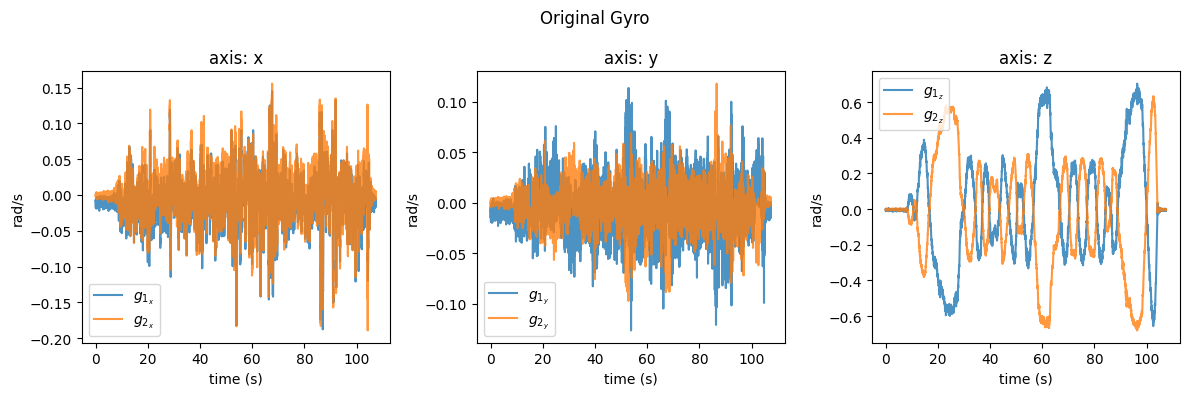

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, ax_label in enumerate(['x', 'y', 'z']):
    ax[i].plot(t, g1[:,i], label=f"$g_{{1_{ax_label}}}$", alpha=0.8)
    ax[i].plot(t, g2[:,i], label=f"$g_{{2_{ax_label}}}$", alpha=0.8)
    ax[i].set_xlabel("time (s)"); ax[i].set_ylabel("rad/s")
    ax[i].set_title(f"axis: {ax_label}")
    ax[i].legend()

plt.suptitle("Original Gyro")
plt.tight_layout()
plt.show()

### Set Up Non-linear Least Squares to Solve Rotation

In [17]:
def f(theta, x, y):
    theta = theta.flatten()
    R = Rotation.from_quat(theta) # x, y, z, w

    y_hat = np.zeros_like(y)
    for i in range(x.shape[0]):
        y_hat[i,:] = (R.as_matrix() @ x[i,:].reshape(-1,1) - y[i,:].reshape(-1,1)).flatten()
    
    return y_hat

def cost(theta, x, y):
    y_hat = f(theta, x, y)

    return np.average(np.linalg.norm(y_hat - y, ord=2, axis=1))



theta0 = np.array([0, 0, 0, 1])
theta_obj = sp.optimize.least_squares(cost, theta0, bounds=(0,1), args=(g1, g2))


### Results for Rotation

In [18]:
theta_hat = theta_obj.x
theta_q = theta_hat[:4]
R_hat = Rotation.from_quat(theta_q)
print(f"q_hat = {np.round(R_hat.as_quat(), 6)}")
print(f"R(q)_hat:\n", R_hat.as_matrix())

q_hat = [0.999784 0.019481 0.       0.007224]
R(q)_hat:
 [[ 9.99240994e-01  3.89532606e-02  2.81467161e-04]
 [ 3.89532606e-02 -9.99136616e-01 -1.44452941e-02]
 [-2.81467161e-04  1.44452941e-02 -9.99895622e-01]]


### Plot Gyro Data After Being Transformed

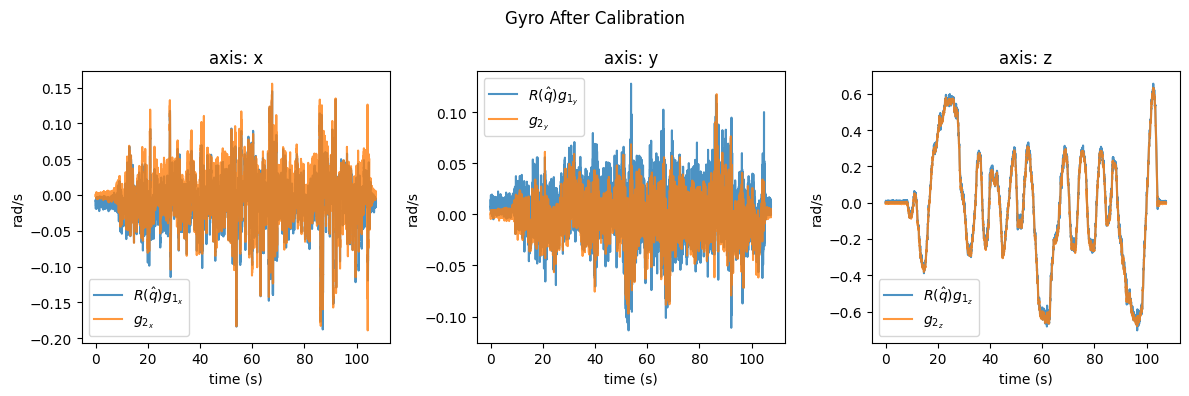

In [20]:
g1_hat = (R_hat.as_matrix() @ g1.T).T

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, ax_label in enumerate(['x', 'y', 'z']):
    ax[i].plot(t, g1_hat[:,i], label=rf"$R(\hat{{q}}) g_{{1_{ax_label}}}$", alpha=0.8)
    ax[i].plot(t, g2[:,i], label=rf"$g_{{2_{ax_label}}}$", alpha=0.8)
    ax[i].set_xlabel("time (s)"); ax[i].set_ylabel("rad/s")
    ax[i].set_title(f"axis: {ax_label}")
    ax[i].legend()

plt.suptitle("Gyro After Calibration")
plt.tight_layout()
plt.show()

## Translation

Since imus are relative sensors, it can be challenging to determine the translation between them. After finding the calibrated rotation matrix, we can treat the two IMUs as point masses on a rigid object and use the following equations from [https://www.mechref.org/dyn/rigid_body_kinematics](https://www.mechref.org/dyn/rigid_body_kinematics) to solve for the translation.
$$\begin{equation} \vec{r}_Q = \vec{r}_P + \vec{r}_{PQ} \tag{1} \end{equation}$$

$$\begin{equation} \vec{v}_Q = \vec{v}_P + \vec{\omega} \times \vec{r}_{PQ} \tag{2} \end{equation}$$

$$\begin{equation} \vec{a}_Q = \vec{a}_P + \vec{\alpha} \times \vec{r}_{PQ} + \vec{\omega} \times \left(\vec{\omega} \times \vec{r}_{PQ} \right) \tag{3} \end{equation}$$

Applying these equations to the two IMUs, let $P$ be the point at IMU 1 ($\vec{r}_1$) and $Q$ be the point at IMU 2 ($\vec{r}_2$). Since we are finding the translation from IMU 1 to IMU 2, IMU 1 is at the origin and we can rewrite equation $(1)$ above as

$$\vec{r}_2 = 0 + \vec{r}_{1,2} \to T = \vec{r}_{1,2}$$

where the relative distance between IMU 1 and IMU 2 is the external translation ($T$). Thus we can rewrite equations $(2)$ and $(3)$ as
$$\vec{v}_2 = \vec{v}_1 + \vec{\omega_1} \times T $$
$$ \begin{equation} \vec{a}_2 = \vec{a}_1 + \vec{\dot \omega_1} \times T + \vec{\omega_1} \times \left(\vec{\omega_1} \times T \right) \tag{4} \end{equation}$$



We can represent the cross products as matrices as seen at [https://en.wikipedia.org/wiki/Cross_product](https://en.wikipedia.org/wiki/Cross_product)
$$ \vec{\omega_1} \times T = 
\begin{bmatrix} 
0 & -\omega_z & \omega_y \\
\omega_z & 0 & -\omega_x \\
-\omega_y & \omega_z & 0
\end{bmatrix} T
$$

This allows us to rewrite cross products in equation $(4)$ as matrices.

$$ \vec{a}_2 = \vec{a}_1 + [\vec{\dot \omega_1}] T + [\vec{\omega_1}] \left([\vec{\omega_1}]T \right) = \vec{a}_1 + \left([\vec{\dot \omega_1}] + [\vec{\omega_1}] [\vec{\omega_1}] \right) T$$

Rearranging a little bit more leads to 

$$ \vec{a}_2 - \vec{a}_1 = \vec{a}_{diff} =  \left([\vec{\dot \omega_1}] + [\vec{\omega_1}]^2 \right) T$$


This follows the traditional linear regression form of $ \left | \left| A\theta - b \right | \right |_2 $ where 
$A(t) = [\vec{\dot \omega_1}] + [\vec{\omega_1}]^2 $, 
$\theta = T$, and 
$b = \vec{a}_{diff}$.


### Set Up Variables

In [21]:
a1_hat = (R_hat.as_matrix() @ a1.T).T

omega = []
omega_dot = []
for i in range(1, len(t)-1):
    omega.append(a1_hat[i])
    dt = t[i+1] - t[i-1]
    o_dot = (a1_hat[i+1] - a1_hat[i-1]) / dt
    omega_dot.append(o_dot)
    if i == 1:
        print(dt)
omega = np.array(omega)
omega_dot = np.array(omega_dot)

    
a1_hat_short = a1_hat[1:-1]
a2_short = a2[1:-1]

print(omega.shape)
print(omega_dot.shape)
print(a1_hat_short.shape)
print(a2_short.shape)

0.019999980926513672
(10737, 3)
(10737, 3)
(10737, 3)
(10737, 3)


In [22]:

def cross_matrix(v):
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])

def f_T(omega, omega_dot):
    return cross_matrix(omega_dot) + cross_matrix(omega) @ cross_matrix(omega)

N = a1_hat_short.shape[0]
A_stack = []
b_stack = []
a_diff = a2_short - a1_hat_short

for i in range(N):
    
    A_i = f_T(omega[i], omega_dot[i])
    
    A_stack.append(A_i)
    b_stack.append(a_diff[i])

A_stack = np.vstack(A_stack)
b_stack = np.hstack(b_stack)



### Plot Original Data

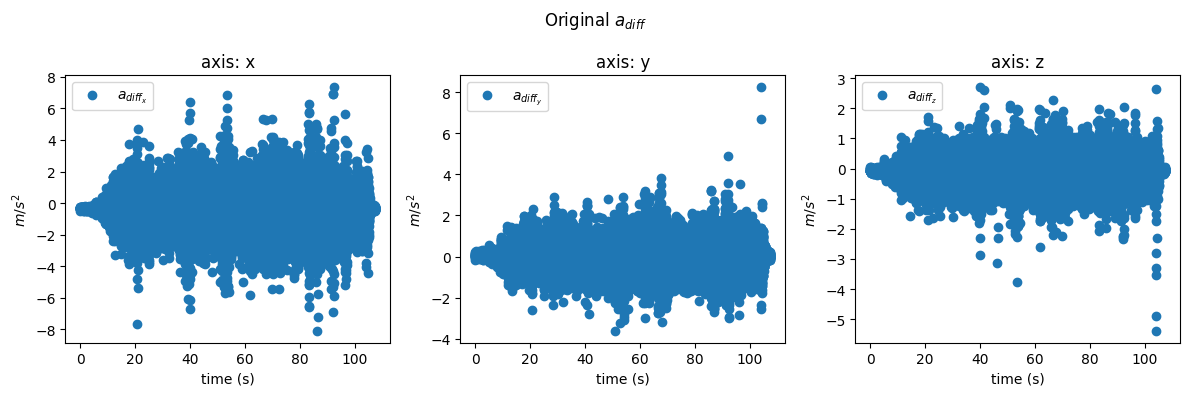

In [23]:

# Plot original data
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, ax_label in enumerate(['x', 'y', 'z']):
    ax[i].scatter(t[1:-1], a_diff[:,i], label=rf"$a_{{diff_{ax_label}}}$")
    ax[i].set_xlabel("time (s)"); ax[i].set_ylabel("$m/s^2$")
    ax[i].set_title(f"axis: {ax_label}")
    ax[i].legend()

plt.suptitle("Original $a_{{diff}}$")
plt.tight_layout()
plt.show()

### Resulting Translation

In [24]:
T = np.linalg.lstsq(A_stack, b_stack, rcond=None)[0]
T

array([ 0.00378549, -0.00038839,  0.00480272])

### Create Plots Showing Results

In [25]:
a_diff_hat = []
a_diff_hat_orig = []

for i in range(a_diff.shape[0]):
    a_diff_hat_orig.append(f_T(omega[i], omega_dot[i]) @ np.array([1, 1, 1]).reshape(-1,1))
    a_diff_hat.append(f_T(omega[i], omega_dot[i]) @ T.reshape(-1,1))

a_diff_hat_orig = np.hstack(a_diff_hat_orig).T
a_diff_hat = np.hstack(a_diff_hat).T

#### Model Before Fitting

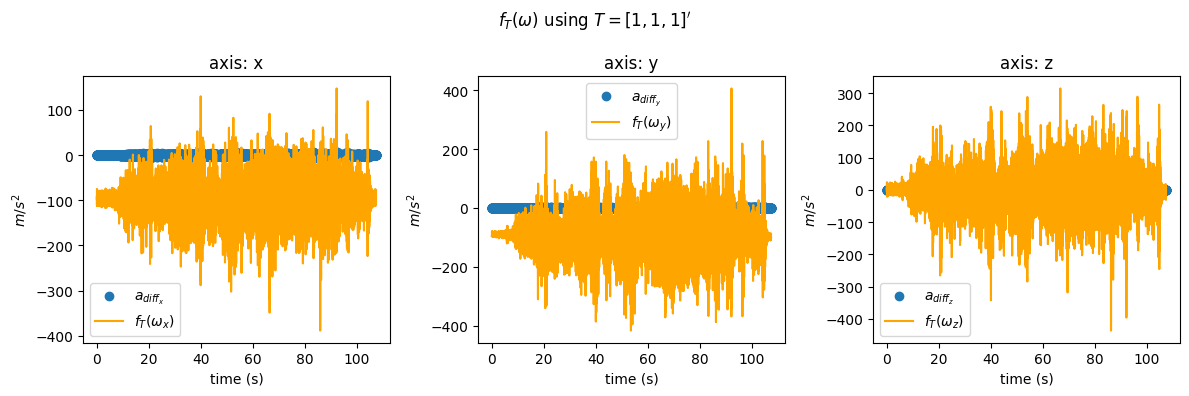

In [26]:

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, ax_label in enumerate(['x', 'y', 'z']):
    ax[i].scatter(t[1:-1], a_diff[:,i], label=rf"$a_{{diff_{ax_label}}}$")
    ax[i].plot(t[1:-1], a_diff_hat_orig[:,i], color='orange', label=rf"$f_{{T}}(\omega_{ax_label})$")
    ax[i].set_xlabel("time (s)"); ax[i].set_ylabel("$m/s^2$")
    ax[i].set_title(f"axis: {ax_label}")
    ax[i].legend()

plt.suptitle(r"$f_T(\omega)$ using $T = [1, 1, 1]'$")
plt.tight_layout()
plt.show()

#### Model After Fitting

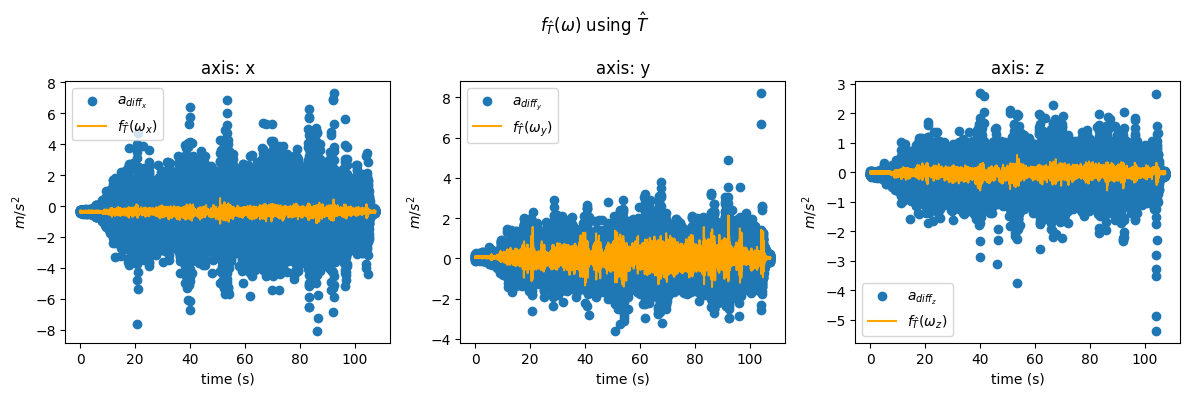

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, ax_label in enumerate(['x', 'y', 'z']):
    ax[i].scatter(t[1:-1], a_diff[:,i], label=rf"$a_{{diff_{ax_label}}}$")
    ax[i].plot(t[1:-1], a_diff_hat[:,i], color='orange', label=rf"$f_{{\hat T}}(\omega_{ax_label})$")
    ax[i].set_xlabel("time (s)"); ax[i].set_ylabel("$m/s^2$")
    ax[i].set_title(f"axis: {ax_label}")
    ax[i].legend()

plt.suptitle(r"$f_{{\hat T}}(\omega)$ using $\hat T$")
plt.tight_layout()
plt.show()